In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats

In [2]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly_merra2.pkl")

pred_XGB   = np.load('/glade/work/hpzhang/LCC_pred/data/MERRA2_output/y_pred_XGB.npy')
pred_NN    = np.load('/glade/work/hpzhang/LCC_pred/data/MERRA2_output/y_pred_neural.npy')
pred_Qu    = np.load('/glade/work/hpzhang/LCC_pred/data/MERRA2_output/y_pred_lr.npy')

df_ceres = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl")

In [3]:
df['LCF_ceres'] = df_ceres.loc['2015-01-01':'2017-06-30','LCF']
df = df.dropna()

In [4]:
df_new = pd.DataFrame({'lat':df['lat'],
                       'lon':df['lon'],
                       'LCF':df['LCF_ceres'],
                       'EIS':df['EIS'],
                       'ECTEI':df['ECTEI'],
                       'ELF':df['ELF'],
                       'y_pred_Qu':pred_Qu,
                       'y_pred_XGB':pred_XGB,
                       'y_pred_NN':pred_NN.flatten(),
                      }, index=df.index)

In [5]:
def get_mse(df):
    x1 = mean_squared_error(df['LCF'], df['y_pred_Qu'], squared=False)
    x2 = mean_squared_error(df['LCF'], df['y_pred_XGB'],squared=False)
    x3 = mean_squared_error(df['LCF'], df['y_pred_NN'], squared=False)
    
    res = pd.DataFrame({'val':[x1,x2,x3]},
                        index=pd.Series(['Qu','XGBoost','NN'], name='model'))
    return(res)

def get_mae(df):
    x1 = mean_absolute_error(df['LCF'], df['y_pred_Qu'])
    x2 = mean_absolute_error(df['LCF'], df['y_pred_XGB'])
    x3 = mean_absolute_error(df['LCF'], df['y_pred_NN'])
    
    res = pd.DataFrame({'val':[x1,x2,x3]},
                        index=pd.Series(['Qu','XGBoost','NN'], name='model'))
    return(res)
def get_cor(df):
    x1, y1 = scipy.stats.pearsonr(df['LCF'], df['EIS'])
    x2, y2 = scipy.stats.pearsonr(df['LCF'], df['ECTEI'])
    x3, y3 = scipy.stats.pearsonr(df['LCF'], df['ELF'])
    
    x4, y4 = scipy.stats.pearsonr(df['LCF'], df['y_pred_Qu'])
    x5, y5 = scipy.stats.pearsonr(df['LCF'], df['y_pred_XGB'])
    x6, y6 = scipy.stats.pearsonr(df['LCF'], df['y_pred_NN'])
    
    res = pd.DataFrame({'r':[x1,x2,x3,x4,x5,x6],
                        'p':[y1,y2,y3,y4,y5,y6]},
                        index=pd.Series(['EIS','ECTEI','ELF','Qu','XGBoost','NN'], name='model'))
    return(res)

In [6]:
df_new['season'] = ''
df_new.loc[df_new.index.month.isin([3,4,5]),   'season']='MAM'
df_new.loc[df_new.index.month.isin([6,7,8]),   'season']='JJA'
df_new.loc[df_new.index.month.isin([9,10,11]), 'season']='SON'
df_new.loc[df_new.index.month.isin([12,1,2]),  'season']='DJF'

lat = df_new.lat
lon = df_new.lon

OCN_index = (lat>=-60)&(lat<=60)
SO_index  = (lat>=-60)&(lat<-50)
SEP_index = ((lat>=-20)&(lat<-10)) & ((lon>=270)&(lon<280))
SEA_index = ((lat>=-20)&(lat<-10)) & ((lon>=0)&(lon<10))
SEI_index = ((lat>=-35)&(lat<-25)) & ((lon>=95)&(lon<105))
NEP_index = ((lat>=20)&(lat<30))   & ((lon>=230)&(lon<240))
NEA_index = (lat>=15)&(lat<25)     & ((lon>=325)&(lon<335))
NA_index  = (lat>=50)&(lat<60)     & ((lon>=315)&(lon<325))
NP_index  = (lat>=40)&(lat<50)     & ((lon>=170)&(lon<180))

df_new['regs'] = np.NaN
df_new.loc[SO_index,  'regs']='SO'
df_new.loc[SEP_index, 'regs']='SEP'
df_new.loc[SEA_index, 'regs']='SEA'
df_new.loc[SEI_index, 'regs']='SEI'
df_new.loc[NEP_index, 'regs']='NEP'
df_new.loc[NEA_index, 'regs']='NEA'
df_new.loc[NA_index,  'regs']='NA'
df_new.loc[NP_index,  'regs']='NP'

df_new['season'] = pd.Categorical(df_new['season'], ['DJF', 'MAM', 'JJA', 'SON'])
df_new['regs']   = pd.Categorical(df_new['regs'],   ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO'])

In [7]:
mse_seas = df_new.groupby('season').apply(get_mse)
cor_seas = df_new.groupby('season').apply(get_cor)
mse_seas.reset_index(level=[0,1], inplace=True)
cor_seas.reset_index(level=[0,1], inplace=True)

mse_regs = df_new.groupby('regs').apply(get_mse)
cor_regs = df_new.groupby('regs').apply(get_cor)
mse_regs.reset_index(level=[0,1], inplace=True)
cor_regs.reset_index(level=[0,1], inplace=True)

In [8]:
# calculate the overall mse and r

mse_all = get_mse(df_new)
r_all   = get_cor(df_new)

mse_all.reset_index(level=[0], inplace=True)
r_all.reset_index(level=[0], inplace=True)


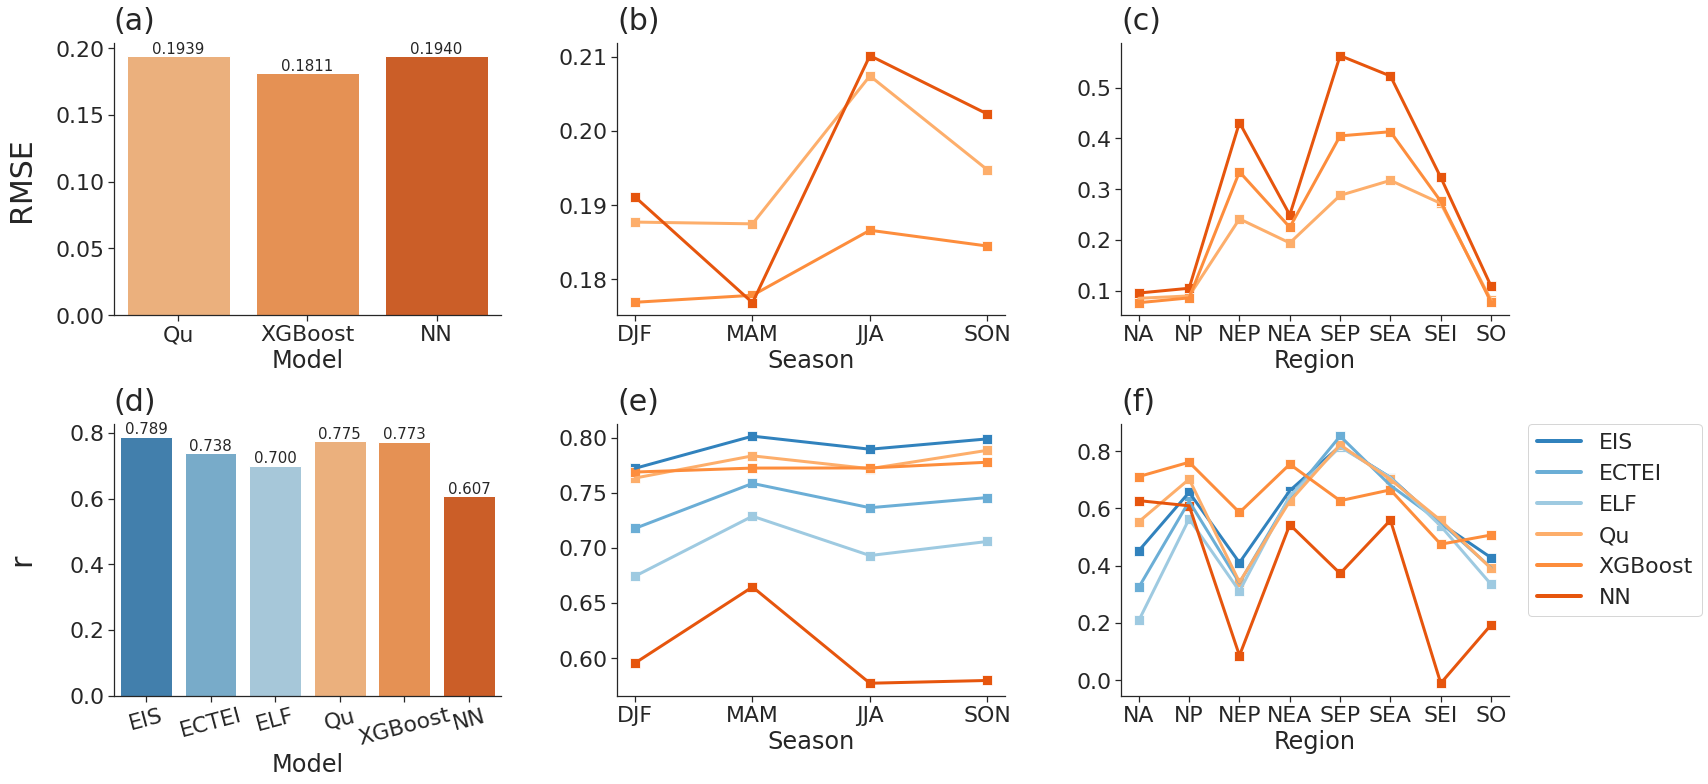

In [9]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 2.0)

fig = plt.figure(figsize=[25, 12])

gd  = (2, 3)
ax1 = plt.subplot2grid(gd, (0, 0))
ax2 = plt.subplot2grid(gd, (0, 1))
ax3 = plt.subplot2grid(gd, (0, 2))
ax4 = plt.subplot2grid(gd, (1, 0))
ax5 = plt.subplot2grid(gd, (1, 1))
ax6 = plt.subplot2grid(gd, (1, 2))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

pal = sns.color_palette("tab20c")
palette1 = [pal[6], pal[5], pal[4]]
palette2 = sns.color_palette("tab20c")[0:3] + palette1

### plot1 ###
g1 = sns.barplot(x="model", y="val", data=mse_all, ax=ax1,
                 palette=palette1)
g1.set(xlabel='Model', ylabel='')

### plot2 ###
g2 = sns.lineplot(x="season", y="val", hue="model", 
                 linewidth=3, 
                 data=mse_seas,
                 ax=ax2,
                 palette=palette1)
g2 = sns.scatterplot(x="season", y="val", hue="model",
                data=mse_seas,
                ax=ax2,
                palette=palette1,
                s = 100,
                marker = 's')
g2.set(xlabel='Season', ylabel='')
g2.get_legend().remove()

### plot3 ###
g3 = sns.lineplot(x="regs", y="val", hue="model", 
                 linewidth=3, 
                 data=mse_regs,
                 ax=ax3,
                 palette=palette1)
g3 = sns.scatterplot(x="regs", y="val", hue="model",
                data=mse_regs,
                ax=ax3,
                palette=palette1,
                s = 100,
                marker = 's')
g3.set(xlabel='Region', ylabel='')
g3.get_legend().remove()

### plot4 ###
g4 = sns.barplot(x="model", y="r", data=r_all, ax=ax4,
                 palette=palette2)
g4.set(xlabel='Model', ylabel='')
g4.tick_params(axis='x', rotation=15)

### plot5 ###
g5 = sns.lineplot(x="season", y="r", hue="model", 
                 linewidth=3, 
                 data=cor_seas,
                 ax=ax5,
                 palette=palette2)
g5 = sns.scatterplot(x="season", y="r", hue="model",
                data=cor_seas,
                ax=ax5,
                palette=palette2,
                s = 100,
                marker = 's')
g5.set(xlabel='Season', ylabel='')
g5.get_legend().remove()

### plot6 ###
g6 = sns.lineplot(x="regs", y="r", hue="model", 
                 linewidth=3, 
                 data=cor_regs,
                 ax=ax6,
                 palette=palette2)
g6 = sns.scatterplot(x="regs", y="r", hue="model",
                data=cor_regs,
                ax=ax6,
                palette=palette2,
                s = 100,
                marker = 's',
                legend=False)
g6.set(xlabel='Region', ylabel='')

leg = g6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
for line in leg.get_lines():
    line.set_linewidth(4.0)

######## add title ##########3
ti = ['(a)','(b)','(c)','(d)','(e)','(f)']

for i, ax in enumerate(axes):
    ax.annotate(ti[i], xy=(0.00, 1.05), xycoords='axes fraction', fontsize=30)

ax1.set_ylabel('RMSE', fontsize=30)
ax1.get_yaxis().set_label_coords(-0.2, 0.5)

ax4.set_ylabel('r', fontsize=30)
ax4.get_yaxis().set_label_coords(-0.2, 0.5)

######## add bar values ##########3
ax1.bar_label(ax1.containers[0], fmt='%.4f', size=15)
ax4.bar_label(ax4.containers[0], fmt='%.3f', size=15)
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)  

  
plt.show()